In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)

import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db = os.getenv("POSTGRES_DATABASE")
db_url = f"postgresql://{user}:{password}@{host}:{port}/{db}"

In [ ]:
engine = create_engine(db_url)

df_data_feed = pd.read_sql("""SELECT * 
                      FROM feed_data
                      WHERE action = 'like'
                      """, 
                      con=engine, 
                      parse_dates="timestamp")

In [3]:
df_data_user = pd.read_sql("""SELECT * 
                      FROM user_data """, 
                      con=engine)

df_data_post = pd.read_sql("""SELECT * 
                      FROM post_text_df """, 
                      con=engine)


In [4]:
df_feed_likes = df_data_feed.copy()

In [5]:
df_post = df_data_post.copy()

In [6]:
df_post.shape

(7023, 3)

In [7]:
df_user = df_data_user.copy()

In [ ]:
text_nn = pd.read_csv('data\PCA_dataset.csv')

In [9]:
text_nn.set_index(df_post.post_id, inplace=True)

In [14]:
for i, col in enumerate(text_nn.columns):
    text_nn.rename({col: f'nn_feature_{i}'}, inplace=True, axis=1)

In [15]:
text_nn

,nn_feature_0,nn_feature_1,nn_feature_2,nn_feature_3,nn_feature_4,nn_feature_5,nn_feature_6,nn_feature_7,nn_feature_8,nn_feature_9
post_id,,,,,,,,,,
1,0.954858,-1.755621,0.206967,1.697693,2.381051,0.014757,-0.139394,0.572930,2.037780,-0.975256
2,3.082158,-0.872362,-1.121495,0.695179,-0.051388,0.234773,-0.309024,0.001493,0.246477,0.529407
3,2.298748,-0.771815,-1.484300,0.921830,-0.043763,0.577127,0.102371,0.678363,1.163933,-1.000728
4,3.830453,-0.031839,-1.308001,-2.101629,-0.484519,-0.095330,0.206701,-0.808279,-0.210362,0.079621
5,2.248869,0.231332,-1.637724,-1.685151,-0.175619,-0.363440,0.877840,-0.201483,-0.476351,0.036897
...,...,...,...,...,...,...,...,...,...,...
7315,-2.656976,-1.065925,-1.688350,-0.109286,-0.562750,-0.528290,0.269968,0.190010,-1.075562,-0.433189
7316,-2.547194,-0.549889,-0.247589,0.458581,-0.235310,-0.913798,0.242953,0.429244,0.440683,-0.022328
7317,-2.438390,-0.878835,-1.034499,-0.249474,-0.589288,-0.427734,0.258952,0.983801,-0.138989,-0.731065


## Обработка данных

### Работа с постами

Topic - категориальная фича

In [21]:
df_post.head()

,post_id,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity
0,1,business,1967,324,0.000204,0.439495,1067.0
1,2,business,2701,448,0.000261,0.290946,637.0
2,3,business,3408,546,0.000275,0.279045,1122.0
3,4,business,1026,173,0.000153,0.525321,1171.0
4,5,business,889,150,0.000149,0.409826,1153.0


In [17]:
df_post = df_post.assign(
    num_of_symbols=lambda x: x['text'].apply(len),                    # кол-во символов в тексте
    num_of_words=lambda x: x['text'].apply(lambda s: len(s.split()))  # ко-во слов в тексте
)

In [18]:
#text - tfIdf

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_post.text)
tfidf_scores = tfidf_matrix.toarray()

df_post = df_post.assign(MeanTfIdf = np.mean(tfidf_scores, axis=1),   # средний tfIdf для слов в тексте
               MaxTfIdf = np.max(tfidf_scores, axis=1))                         # tfIdf для самого важного слова в тексте

In [19]:
df_post.drop('text', axis=1, inplace=True)

In [20]:
post_interactions = df_feed_likes.groupby('post_id').action.count()
df_post['post_popularity'] = df_post['post_id'].map(post_interactions).fillna(0)

### Работа с юзерами

country, city, exp_group, os, source, gender укажем как категориальные

In [22]:
df_user.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [23]:
like_counts = df_feed_likes.groupby('user_id').action.count()
df_user['user_like_amount'] = df_user['user_id'].map(like_counts).fillna(0)    #сколько лайкал конкретный юзер

### Мэтчим таблицы для обучения, довливаем дополнительные фичи

In [24]:
df_data = pd.read_sql("""SELECT * 
                      FROM feed_data
                      LIMIT 1000000""", 
                      con=engine, 
                      parse_dates="timestamp")

In [25]:
df_data_copy = df_data.copy()

In [26]:
df = pd.merge(df_data_copy,
              df_post,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity
0,2021-11-04 10:14:10,164942,2837,like,0,covid,140,18,0.000076,0.452609,701.0
1,2021-11-04 10:14:12,164942,2297,view,0,tech,2211,353,0.000219,0.410664,693.0
2,2021-11-04 10:15:35,164942,4751,view,0,movie,1640,300,0.000204,0.368229,667.0
3,2021-11-04 10:16:34,164942,5804,view,0,movie,929,166,0.000185,0.316579,699.0
4,2021-11-04 10:17:23,164942,3151,view,0,covid,138,18,0.000070,0.562951,743.0


In [27]:
df = pd.merge(df,
              df_user,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,user_like_amount
0,2021-11-04 10:14:10,164942,2837,like,0,covid,140,18,0.000076,0.452609,701.0,1,44,Russia,Maykop,1,Android,organic,64.0
1,2021-11-04 10:14:12,164942,2297,view,0,tech,2211,353,0.000219,0.410664,693.0,1,44,Russia,Maykop,1,Android,organic,64.0
2,2021-11-04 10:15:35,164942,4751,view,0,movie,1640,300,0.000204,0.368229,667.0,1,44,Russia,Maykop,1,Android,organic,64.0
3,2021-11-04 10:16:34,164942,5804,view,0,movie,929,166,0.000185,0.316579,699.0,1,44,Russia,Maykop,1,Android,organic,64.0
4,2021-11-04 10:17:23,164942,3151,view,0,covid,138,18,0.000070,0.562951,743.0,1,44,Russia,Maykop,1,Android,organic,64.0


In [28]:
# some new features
 
df['hour'] = df.timestamp.dt.hour
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['week_day'] = df.timestamp.dt.dayofweek

In [29]:
#df.head()
df[df.action != 'like'].sort_values("timestamp", ascending=True)

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,user_like_amount,hour,month,day,week_day
9990,2021-10-01 06:02:14,22865,1381,view,0,sport,2113,386,0.000231,0.260614,2846.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4
9991,2021-10-01 06:02:31,22865,3222,view,0,covid,140,20,0.000073,0.372898,2575.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4
9992,2021-10-01 06:03:15,22865,6592,view,0,movie,912,178,0.000192,0.246410,2619.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4
9993,2021-10-01 06:05:39,22865,6048,view,0,movie,1091,187,0.000162,0.515672,2577.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4
881796,2021-10-01 06:06:44,111329,3521,view,0,covid,132,20,0.000072,0.425822,1134.0,1,31,Russia,Severodvinsk,0,Android,organic,57.0,6,10,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39935,2021-12-29 23:40:13,22877,3511,view,0,covid,140,19,0.000079,0.407680,955.0,0,18,Russia,Usinsk,1,iOS,ads,100.0,23,12,29,2
39936,2021-12-29 23:41:45,22877,7219,view,1,movie,4495,818,0.000291,0.308102,725.0,0,18,Russia,Usinsk,1,iOS,ads,100.0,23,12,29,2
39938,2021-12-29 23:42:53,22877,1313,view,0,politics,959,162,0.000165,0.293618,1577.0,0,18,Russia,Usinsk,1,iOS,ads,100.0,23,12,29,2
39939,2021-12-29 23:43:15,22877,7110,view,0,movie,1559,277,0.000215,0.288918,686.0,0,18,Russia,Usinsk,1,iOS,ads,100.0,23,12,29,2


In [30]:
df = pd.merge(df,
              text_nn,
              on='post_id',
              how='left')

In [31]:
df

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,user_like_amount,hour,month,day,week_day,nn_feature_0,nn_feature_1,nn_feature_2,nn_feature_3,nn_feature_4,nn_feature_5,nn_feature_6,nn_feature_7,nn_feature_8,nn_feature_9
0,2021-11-04 10:14:10,164942,2837,like,0,covid,140,18,0.000076,0.452609,701.0,1,44,Russia,Maykop,1,Android,organic,64.0,10,11,4,3,-0.507282,1.832709,-1.255673,0.424032,0.183443,0.549816,0.776228,0.179921,-0.043640,-0.161978
1,2021-11-04 10:14:12,164942,2297,view,0,tech,2211,353,0.000219,0.410664,693.0,1,44,Russia,Maykop,1,Android,organic,64.0,10,11,4,3,3.942313,-1.117730,-0.995771,0.458180,-0.780116,-0.161628,-0.948516,-0.247974,-0.050654,-0.067732
2,2021-11-04 10:15:35,164942,4751,view,0,movie,1640,300,0.000204,0.368229,667.0,1,44,Russia,Maykop,1,Android,organic,64.0,10,11,4,3,-0.913805,-2.100171,1.090783,-0.859373,-0.371749,0.768518,0.095749,-0.752605,0.026583,0.117827
3,2021-11-04 10:16:34,164942,5804,view,0,movie,929,166,0.000185,0.316579,699.0,1,44,Russia,Maykop,1,Android,organic,64.0,10,11,4,3,-0.175614,-0.504349,1.509455,-0.544272,-1.678838,-0.219774,0.034138,2.184614,0.471782,-1.801807
4,2021-11-04 10:17:23,164942,3151,view,0,covid,138,18,0.000070,0.562951,743.0,1,44,Russia,Maykop,1,Android,organic,64.0,10,11,4,3,-0.257867,3.429499,-0.191235,0.444324,0.730841,0.410389,-0.430350,-0.491020,-0.606011,0.407375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2021-11-10 23:38:44,67355,1266,view,0,politics,1911,330,0.000197,0.376379,2801.0,1,34,Russia,Rostov,2,iOS,ads,96.0,23,11,10,2,1.610886,-1.209845,1.224137,0.472501,1.652404,-0.780382,0.167042,0.634649,0.824474,0.591471
999996,2021-11-10 23:39:53,67355,1342,view,1,politics,2546,439,0.000224,0.337045,2861.0,1,34,Russia,Rostov,2,iOS,ads,96.0,23,11,10,2,3.676196,-0.950274,0.745180,0.168875,-0.005680,-0.509843,0.076310,0.412401,0.104213,0.445210
999997,2021-11-10 23:40:51,67355,1342,like,0,politics,2546,439,0.000224,0.337045,2861.0,1,34,Russia,Rostov,2,iOS,ads,96.0,23,11,10,2,3.676196,-0.950274,0.745180,0.168875,-0.005680,-0.509843,0.076310,0.412401,0.104213,0.445210
999998,2021-11-17 09:08:36,67355,3374,view,0,covid,140,20,0.000076,0.429560,2610.0,1,34,Russia,Rostov,2,iOS,ads,96.0,9,11,17,2,0.011399,2.351218,0.328513,0.854680,-0.956452,-1.394092,-0.285919,-0.523713,0.546041,-0.389255


## Train, Test

In [32]:
#фильтрация для формирования трэин\тест
# плюсом фильтруем по action и удаляем действия с лайком - нужная информация из таких взаимодействий ранее была выделена

df_views = df[df.action != 'like'].sort_values("timestamp", ascending=True, ignore_index=True)
df_views.drop(['timestamp', 'action'], inplace=True, axis=1)

In [33]:
df_views.head()

,user_id,post_id,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,user_like_amount,hour,month,day,week_day,nn_feature_0,nn_feature_1,nn_feature_2,nn_feature_3,nn_feature_4,nn_feature_5,nn_feature_6,nn_feature_7,nn_feature_8,nn_feature_9
0,22865,1381,0,sport,2113,386,0.000231,0.260614,2846.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4,0.529081,-2.425354,2.460041,1.788277,1.609966,0.203116,0.995387,-0.405244,-0.841320,0.318020
1,22865,3222,0,covid,140,20,0.000073,0.372898,2575.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4,0.381055,3.057539,1.572661,0.404002,-0.925597,-0.965744,-0.172602,0.010211,-0.021578,0.326868
2,22865,6592,0,movie,912,178,0.000192,0.246410,2619.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4,-1.830105,-0.919599,-1.125863,-0.345657,-0.922479,-1.222897,0.224346,0.230421,0.962211,-0.255982
3,22865,6048,0,movie,1091,187,0.000162,0.515672,2577.0,1,17,Russia,Omsk,4,Android,ads,35.0,6,10,1,4,-0.496832,-0.793866,0.275862,-0.635198,-1.130174,-0.385232,0.550967,0.749072,0.719225,-0.992442
4,111329,3521,0,covid,132,20,0.000072,0.425822,1134.0,1,31,Russia,Severodvinsk,0,Android,organic,57.0,6,10,1,4,-0.273004,3.609245,0.982218,0.746430,-0.179307,-0.462861,-0.376528,-0.592091,-0.870729,0.262884


In [34]:
df_views.shape[1] 

31

In [35]:
df_views.drop(['user_id', 'post_id'], axis=1, inplace=True)

In [36]:
train_data = df_views.iloc[:-1000].copy()
test_data = df_views.iloc[-1000:].copy()

In [37]:
X_train = train_data.drop('target', axis=1)
y_train = train_data.target

In [38]:
X_test = test_data.drop('target', axis=1)
y_test = test_data.target

In [39]:
df_views.columns

Index(['target', 'topic', 'num_of_symbols', 'num_of_words', 'MeanTfIdf',
       'MaxTfIdf', 'post_popularity', 'gender', 'age', 'country', 'city',
       'exp_group', 'os', 'source', 'user_like_amount', 'hour', 'month', 'day',
       'week_day', 'nn_feature_0', 'nn_feature_1', 'nn_feature_2',
       'nn_feature_3', 'nn_feature_4', 'nn_feature_5', 'nn_feature_6',
       'nn_feature_7', 'nn_feature_8', 'nn_feature_9'],
      dtype='object')

In [40]:
from catboost import CatBoostClassifier

cat_cols =['topic', 'gender',
           'country', 'city', 'exp_group', 'os', 'source',
            'hour', 'month', 'day', 'week_day']


catboost = CatBoostClassifier(iterations=110,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, cat_cols)

0:	learn: 0.3601009	total: 405ms	remaining: 44.2s
1:	learn: 0.3489905	total: 537ms	remaining: 29s
2:	learn: 0.3471039	total: 659ms	remaining: 23.5s
3:	learn: 0.3457691	total: 791ms	remaining: 21s
4:	learn: 0.3448526	total: 941ms	remaining: 19.8s
5:	learn: 0.3428466	total: 1.06s	remaining: 18.3s
6:	learn: 0.3423451	total: 1.17s	remaining: 17.2s
7:	learn: 0.3420572	total: 1.27s	remaining: 16.2s
8:	learn: 0.3410268	total: 1.36s	remaining: 15.3s
9:	learn: 0.3407946	total: 1.46s	remaining: 14.6s
10:	learn: 0.3399711	total: 1.59s	remaining: 14.3s
11:	learn: 0.3397525	total: 1.7s	remaining: 13.9s
12:	learn: 0.3396049	total: 1.8s	remaining: 13.4s
13:	learn: 0.3394002	total: 1.9s	remaining: 13s
14:	learn: 0.3392363	total: 2s	remaining: 12.7s
15:	learn: 0.3390552	total: 2.1s	remaining: 12.3s
16:	learn: 0.3389981	total: 2.19s	remaining: 12s
17:	learn: 0.3388320	total: 2.29s	remaining: 11.7s
18:	learn: 0.3387286	total: 2.39s	remaining: 11.4s
19:	learn: 0.3386617	total: 2.48s	remaining: 11.2s
20:	l

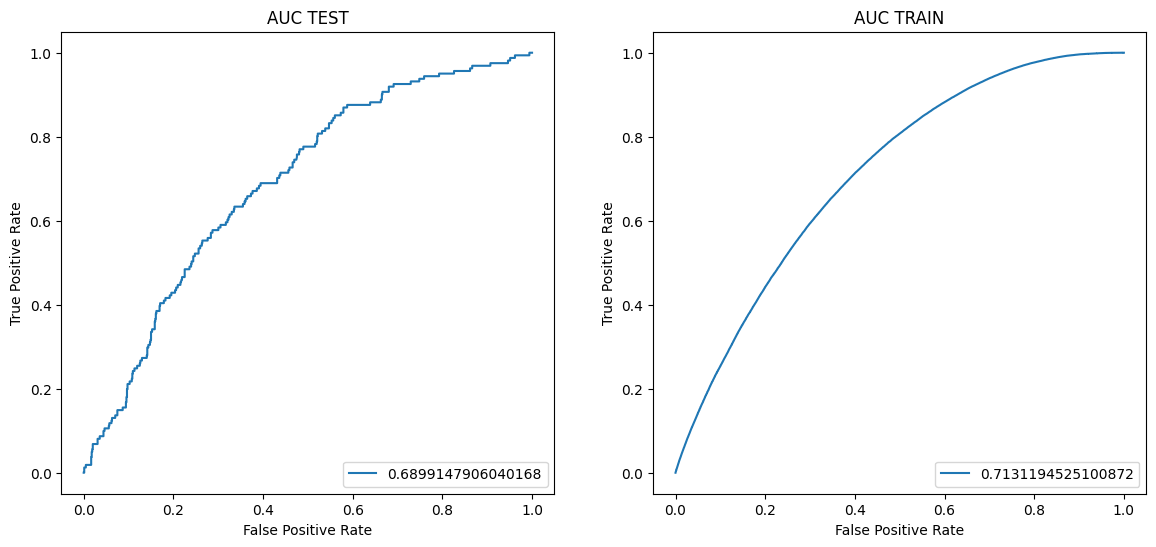

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve, RocCurveDisplay, auc

fig, ax = plt.subplots(1, 2, figsize=(14,6))

FPR, TPR, thresh = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=FPR, tpr=TPR).plot(label = auc(FPR, TPR), ax=ax[0])
ax[0].set_title('AUC TEST')

FPR, TPR, thresh = roc_curve(y_train, catboost.predict_proba(X_train)[:, 1])
RocCurveDisplay(fpr=FPR, tpr=TPR).plot(label = auc(FPR, TPR), ax=ax[1])
ax[1].set_title('AUC TRAIN')
plt.show()

In [42]:
catboost.save_model('catboost_model6', format="cbm")

## Передача в БД

In [43]:
text_nn

,nn_feature_0,nn_feature_1,nn_feature_2,nn_feature_3,nn_feature_4,nn_feature_5,nn_feature_6,nn_feature_7,nn_feature_8,nn_feature_9
post_id,,,,,,,,,,
1,0.954858,-1.755621,0.206967,1.697693,2.381051,0.014757,-0.139394,0.572930,2.037780,-0.975256
2,3.082158,-0.872362,-1.121495,0.695179,-0.051388,0.234773,-0.309024,0.001493,0.246477,0.529407
3,2.298748,-0.771815,-1.484300,0.921830,-0.043763,0.577127,0.102371,0.678363,1.163933,-1.000728
4,3.830453,-0.031839,-1.308001,-2.101629,-0.484519,-0.095330,0.206701,-0.808279,-0.210362,0.079621
5,2.248869,0.231332,-1.637724,-1.685151,-0.175619,-0.363440,0.877840,-0.201483,-0.476351,0.036897
...,...,...,...,...,...,...,...,...,...,...
7315,-2.656976,-1.065925,-1.688350,-0.109286,-0.562750,-0.528290,0.269968,0.190010,-1.075562,-0.433189
7316,-2.547194,-0.549889,-0.247589,0.458581,-0.235310,-0.913798,0.242953,0.429244,0.440683,-0.022328
7317,-2.438390,-0.878835,-1.034499,-0.249474,-0.589288,-0.427734,0.258952,0.983801,-0.138989,-0.731065


In [63]:
df_user

,user_id,gender,age,country,city,exp_group,os,source,user_like_amount
0,200,1,34,Russia,Degtyarsk,3,Android,ads,43.0
1,201,0,37,Russia,Abakan,0,Android,ads,58.0
2,202,1,17,Russia,Smolensk,4,Android,ads,87.0
3,203,0,18,Russia,Moscow,1,iOS,ads,61.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,23.0
...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,20.0
163201,168549,0,18,Russia,Tula,2,Android,organic,22.0
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,38.0
163203,168551,0,38,Russia,Moscow,3,iOS,organic,48.0


In [64]:
df_post

,post_id,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity
0,1,business,1967,324,0.000204,0.439495,1067.0
1,2,business,2701,448,0.000261,0.290946,637.0
2,3,business,3408,546,0.000275,0.279045,1122.0
3,4,business,1026,173,0.000153,0.525321,1171.0
4,5,business,889,150,0.000149,0.409826,1153.0
...,...,...,...,...,...,...,...
7018,7315,movie,803,159,0.000168,0.226524,2619.0
7019,7316,movie,800,150,0.000172,0.333130,677.0
7020,7317,movie,636,111,0.000141,0.507582,731.0
7021,7318,movie,728,140,0.000166,0.263741,680.0


In [ ]:
TABLE_CUSTOM_POST = os.getenv("TABLE_CUSTOM_POST")
TABLE_CUSTOM_USERS = os.getenv("TABLE_CUSTOM_USERS")
TABLE_CUSTOM_POST_FEATURES = os.getenv("TABLE_CUSTOM_POST_FEATURES")

In [ ]:
text_nn.to_sql(f'{TABLE_CUSTOM_POST_FEATURES}', engine, if_exists='replace', index=True)

23

In [ ]:
df_user.to_sql(f'{TABLE_CUSTOM_USERS}', engine, if_exists='replace', index=False)

205

In [ ]:
df_post.to_sql(f'{TABLE_CUSTOM_POST}', engine, if_exists='replace', index=False)

23

In [ ]:
x = pd.read_sql("""SELECT * 
                    FROM {TABLE_CUSTOM_POST_FEATURES};
                    """, con=engine)

In [5]:
x

,post_id,nn_feature_0,nn_feature_1,nn_feature_2,nn_feature_3,nn_feature_4,nn_feature_5,nn_feature_6,nn_feature_7,nn_feature_8,nn_feature_9
0,1,0.954858,-1.755621,0.206967,1.697693,2.381051,0.014757,-0.139394,0.572930,2.037780,-0.975256
1,2,3.082158,-0.872362,-1.121495,0.695179,-0.051388,0.234773,-0.309024,0.001493,0.246477,0.529407
2,3,2.298748,-0.771815,-1.484300,0.921830,-0.043763,0.577127,0.102371,0.678363,1.163933,-1.000728
3,4,3.830453,-0.031839,-1.308001,-2.101629,-0.484519,-0.095330,0.206701,-0.808279,-0.210362,0.079621
4,5,2.248869,0.231332,-1.637724,-1.685151,-0.175619,-0.363440,0.877840,-0.201483,-0.476351,0.036897
...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,-2.656976,-1.065925,-1.688350,-0.109286,-0.562750,-0.528290,0.269968,0.190010,-1.075562,-0.433189
7019,7316,-2.547194,-0.549889,-0.247589,0.458581,-0.235310,-0.913798,0.242953,0.429244,0.440683,-0.022328
7020,7317,-2.438390,-0.878835,-1.034499,-0.249474,-0.589288,-0.427734,0.258952,0.983801,-0.138989,-0.731065
7021,7318,-2.499132,-1.253244,-0.025749,-0.992778,0.589764,0.471239,0.410803,-0.300642,-0.129530,-0.345278
